# Creating and Backtesting Pivot Point Strategies

## Getting the (raw) Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("EURUSD_pivot.csv", index_col = "time", parse_dates = ["time"])
data

,Open,High,Low,Close
time,,,,
2019-01-01 22:00:00,1.14649,1.14658,1.14630,1.14648
2019-01-01 22:30:00,1.14653,1.14653,1.14616,1.14641
2019-01-01 23:00:00,1.14640,1.14678,1.14579,1.14665
2019-01-01 23:30:00,1.14669,1.14672,1.14614,1.14614
2019-01-02 00:00:00,1.14614,1.14628,1.14575,1.14582
...,...,...,...,...
2020-12-30 21:30:00,1.22947,1.23019,1.22946,1.23000
2020-12-30 22:00:00,1.22979,1.23000,1.22935,1.22956
2020-12-30 22:30:00,1.22958,1.22984,1.22945,1.22970


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24856 entries, 2019-01-01 22:00:00 to 2020-12-30 23:30:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    24856 non-null  float64
 1   High    24856 non-null  float64
 2   Low     24856 non-null  float64
 3   Close   24856 non-null  float64
dtypes: float64(4)
memory usage: 970.9 KB


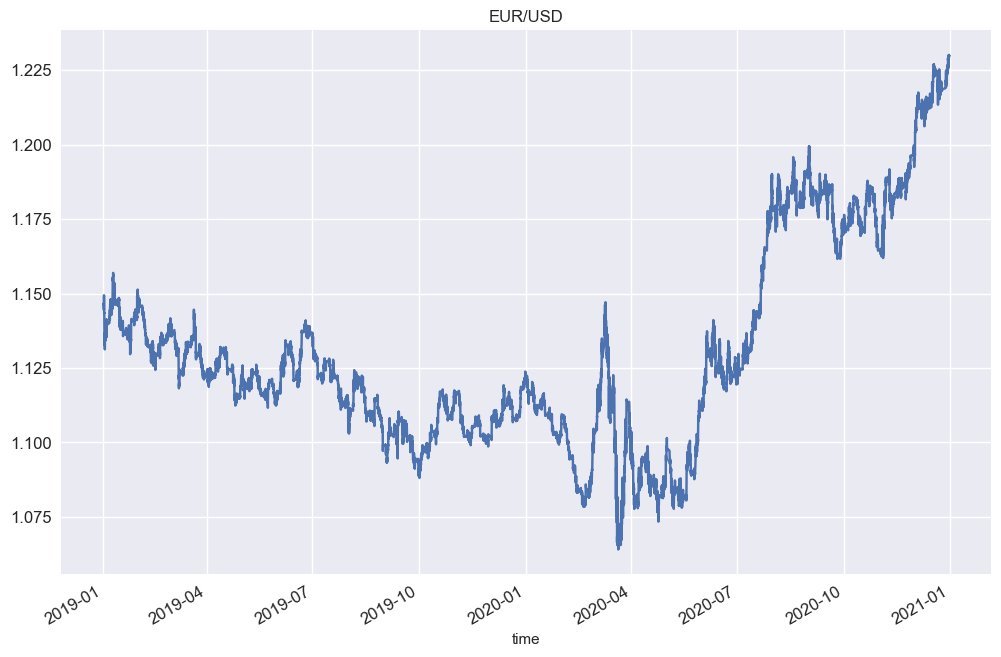

In [4]:
data.Close.plot(figsize = (12, 8), title = "EUR/USD", fontsize = 12)
plt.show()

## Preparing the Data (1) - Timezone Conversion

In [5]:
print(data.index.tz)

None


In [6]:
data = data.tz_localize("UTC") # localize to UTC time
data

,Open,High,Low,Close
time,,,,
2019-01-01 22:00:00+00:00,1.14649,1.14658,1.14630,1.14648
2019-01-01 22:30:00+00:00,1.14653,1.14653,1.14616,1.14641
2019-01-01 23:00:00+00:00,1.14640,1.14678,1.14579,1.14665
2019-01-01 23:30:00+00:00,1.14669,1.14672,1.14614,1.14614
2019-01-02 00:00:00+00:00,1.14614,1.14628,1.14575,1.14582
...,...,...,...,...
2020-12-30 21:30:00+00:00,1.22947,1.23019,1.22946,1.23000
2020-12-30 22:00:00+00:00,1.22979,1.23000,1.22935,1.22956
2020-12-30 22:30:00+00:00,1.22958,1.22984,1.22945,1.22970


In [7]:
data.index

DatetimeIndex(['2019-01-01 22:00:00+00:00', '2019-01-01 22:30:00+00:00',
               '2019-01-01 23:00:00+00:00', '2019-01-01 23:30:00+00:00',
               '2019-01-02 00:00:00+00:00', '2019-01-02 00:30:00+00:00',
               '2019-01-02 01:00:00+00:00', '2019-01-02 01:30:00+00:00',
               '2019-01-02 02:00:00+00:00', '2019-01-02 02:30:00+00:00',
               ...
               '2020-12-30 19:00:00+00:00', '2020-12-30 19:30:00+00:00',
               '2020-12-30 20:00:00+00:00', '2020-12-30 20:30:00+00:00',
               '2020-12-30 21:00:00+00:00', '2020-12-30 21:30:00+00:00',
               '2020-12-30 22:00:00+00:00', '2020-12-30 22:30:00+00:00',
               '2020-12-30 23:00:00+00:00', '2020-12-30 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=24856, freq=None)

In [8]:
data = data.tz_convert("US/Eastern") # convert to US/Eastern (NY) time
data

,Open,High,Low,Close
time,,,,
2019-01-01 17:00:00-05:00,1.14649,1.14658,1.14630,1.14648
2019-01-01 17:30:00-05:00,1.14653,1.14653,1.14616,1.14641
2019-01-01 18:00:00-05:00,1.14640,1.14678,1.14579,1.14665
2019-01-01 18:30:00-05:00,1.14669,1.14672,1.14614,1.14614
2019-01-01 19:00:00-05:00,1.14614,1.14628,1.14575,1.14582
...,...,...,...,...
2020-12-30 16:30:00-05:00,1.22947,1.23019,1.22946,1.23000
2020-12-30 17:00:00-05:00,1.22979,1.23000,1.22935,1.22956
2020-12-30 17:30:00-05:00,1.22958,1.22984,1.22945,1.22970


In [9]:
print(data.index.tz)

US/Eastern


## Preparing the Data (2) - Resampling to daily (NY Close)

In [10]:
close = data.Close.to_frame().copy()

In [11]:
close.head(15)

,Close
time,
2019-01-01 17:00:00-05:00,1.14648
2019-01-01 17:30:00-05:00,1.14641
2019-01-01 18:00:00-05:00,1.14665
2019-01-01 18:30:00-05:00,1.14614
2019-01-01 19:00:00-05:00,1.14582
2019-01-01 19:30:00-05:00,1.14565
2019-01-01 20:00:00-05:00,1.14524
2019-01-01 20:30:00-05:00,1.14523
2019-01-01 21:00:00-05:00,1.14485


In [12]:
close.resample("D").last()

,Close
time,
2019-01-01 00:00:00-05:00,1.14450
2019-01-02 00:00:00-05:00,1.13673
2019-01-03 00:00:00-05:00,1.13944
2019-01-04 00:00:00-05:00,1.13951
2019-01-05 00:00:00-05:00,NaN
...,...
2020-12-26 00:00:00-05:00,NaN
2020-12-27 00:00:00-05:00,1.22104
2020-12-28 00:00:00-05:00,1.22398


In [13]:
close.resample("D", offset = "17h").last().dropna()

,Close
time,
2019-01-01 17:00:00-05:00,1.13447
2019-01-02 17:00:00-05:00,1.13942
2019-01-03 17:00:00-05:00,1.13951
2019-01-06 17:00:00-05:00,1.14748
2019-01-07 17:00:00-05:00,1.14417
...,...
2020-12-23 17:00:00-05:00,1.21849
2020-12-27 17:00:00-05:00,1.22152
2020-12-28 17:00:00-05:00,1.22502


## Preparing the Data (3) - OHLC Resampling

In [14]:
agg_dict = {"Open":"first",
            "High":"max",
            "Low":"min",
            "Close":"last"
           }

In [15]:
data.resample("D", offset = "17h").agg(agg_dict).dropna()

,Open,High,Low,Close
time,,,,
2019-01-01 17:00:00-05:00,1.14649,1.14970,1.13250,1.13447
2019-01-02 17:00:00-05:00,1.13431,1.14112,1.13091,1.13942
2019-01-03 17:00:00-05:00,1.13930,1.14190,1.13458,1.13951
2019-01-06 17:00:00-05:00,1.13974,1.14827,1.13972,1.14748
2019-01-07 17:00:00-05:00,1.14773,1.14848,1.14219,1.14417
...,...,...,...,...
2020-12-23 17:00:00-05:00,1.21873,1.22158,1.21774,1.21849
2020-12-27 17:00:00-05:00,1.21892,1.22504,1.21812,1.22152
2020-12-28 17:00:00-05:00,1.22145,1.22752,1.22086,1.22502


In [16]:
daily_data = data.resample("D", offset = "17h").agg(agg_dict).dropna()
daily_data

,Open,High,Low,Close
time,,,,
2019-01-01 17:00:00-05:00,1.14649,1.14970,1.13250,1.13447
2019-01-02 17:00:00-05:00,1.13431,1.14112,1.13091,1.13942
2019-01-03 17:00:00-05:00,1.13930,1.14190,1.13458,1.13951
2019-01-06 17:00:00-05:00,1.13974,1.14827,1.13972,1.14748
2019-01-07 17:00:00-05:00,1.14773,1.14848,1.14219,1.14417
...,...,...,...,...
2020-12-23 17:00:00-05:00,1.21873,1.22158,1.21774,1.21849
2020-12-27 17:00:00-05:00,1.21892,1.22504,1.21812,1.22152
2020-12-28 17:00:00-05:00,1.22145,1.22752,1.22086,1.22502


In [17]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520 entries, 2019-01-01 17:00:00-05:00 to 2020-12-30 17:00:00-05:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    520 non-null    float64
 1   High    520 non-null    float64
 2   Low     520 non-null    float64
 3   Close   520 non-null    float64
dtypes: float64(4)
memory usage: 20.3 KB


In [18]:
data

,Open,High,Low,Close
time,,,,
2019-01-01 17:00:00-05:00,1.14649,1.14658,1.14630,1.14648
2019-01-01 17:30:00-05:00,1.14653,1.14653,1.14616,1.14641
2019-01-01 18:00:00-05:00,1.14640,1.14678,1.14579,1.14665
2019-01-01 18:30:00-05:00,1.14669,1.14672,1.14614,1.14614
2019-01-01 19:00:00-05:00,1.14614,1.14628,1.14575,1.14582
...,...,...,...,...
2020-12-30 16:30:00-05:00,1.22947,1.23019,1.22946,1.23000
2020-12-30 17:00:00-05:00,1.22979,1.23000,1.22935,1.22956
2020-12-30 17:30:00-05:00,1.22958,1.22984,1.22945,1.22970
